# Training Resnet18 on CIFAR-10

### Load and normalizing the CIFAR10 training and test datasets using torchvision

In [1]:
# Loading and normalizing CIFAR-10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
!pip install torchsummary
from torchsummary import summary

In [2]:
transform = transforms.Compose( #transforms 함수 미리 정의
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
#위의 normalize는 는 image = (image - mean) / std 를 시켜줌. 3 개인 이유는 각 채널마다 mean, std를 적용시켜야 되기 때문. 
#input value [0,1] -> [-1, 1] range로 바뀜. 예를 들어서, minimum value 0은 (0-0.5)/0.5 = -1, maximum value 1은 (1-0.5)/0.5 = 1 이 된다.

batch_size = 8
#load dataset
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, #torchvision의 dataset에서 CIFAR10 dataset다운 받음. 
#                                       download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform)
## define MNIST dataset
trainset = torchvision.datasets.MNIST(root = "./data", train = True, transform = transform, download = True)
testset = torchvision.datasets.MNIST(root = "./data", train = False, transform = transform, download = True)
## mnist: 1*28*28
#define dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 
#            'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('0', '1', '2', '3', '4', 
           '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/root/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1641297139223/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


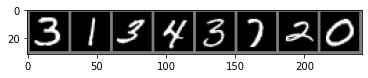

    3     1     3     4     3     7     2     0


In [3]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Define Resnet18

![title](resnet.png)

In [4]:
class BasicBlock(nn.Module):
    ### implement this
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        ##forward ## conv, bn, relu, conv, bn , addition , relu
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        
        self.relu = nn.ReLU()
        
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, bias = False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        ## input channel: 64, out channel: 128
        # residual_function -> 128 channel, shortcut 64
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

* conv1: 7*7, 64 channels, stride 2, padding 3
* maxpool: 3*3, stride 2, padding 1
* conv2_1: residual block, in_channels: 64, out_channels: 64
* conv2_2: residual block, in_channels: 64, out_channels: 64
* conv3_1: residual block, in_channels: 64, out_channels: 128
* conv3_2: residual block, in_channels: 128, out_channels: 128
* conv4_1: residual block, in_channels: 128, out_channels: 256
* conv4_2: residual block, in_channels: 256, out_channels: 256
* conv5_1: residual block, in_channels: 256, out_channels: 512
* conv5_2: residual block, in_channels: 512, out_channels: 512
* average pooling
* fc layer

In [5]:
class ResNet18(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet18, self).__init__()
        ### implement this
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
        
        self.conv2_1 = block(64, 64)
        self.conv2_2 = block(64, 64)
        
        self.conv3_1 = block(64, 128)
        self.conv3_2 = block(128, 128)
        
        self.conv4_1 = block(128, 256)
        self.conv4_2 = block(256, 256)
        
        self.conv5_1 = block(256, 512)
        self.conv5_2 = block(512, 512)
        
        ## average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # h*w ->1*1
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self,x):
        # x:[batch, 3, 32, 32]
        ### implement this
        
        x = self.conv1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x) # [batch, 512, h, w]
        
        x = self.avg_pool(x) # [batch, 512, 1, 1]
        
        x = x.view(x.size(0), -1) # [batch, 512]
        
        x = self.fc(x) #[batch, 10]

        return x

In [6]:
net = ResNet18(BasicBlock)
summary(net, batch_size=-1, input_size=(1, 32, 32), device='cpu')
net = net.cuda()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Define a Loss function and optimizer
* Use Classification Cross-Entropy loss
* Use Adam with learning rate 0.0001 

In [7]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss에 softmax까지 구현되어있기 때문에 모델에 softmax를 선언하지 않아도 됨. 
optimizer = optim.Adam(net.parameters(), lr=0.0001)

### Train the network on the training data

In [8]:
def train(net, optimizer, epoch):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
            
def test(net):
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    net.eval()
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        for idx in range(10): 
            label_idx = (labels == idx)
            if label_idx.sum().item() == 0: 
                continue
            class_correct[idx] += labels[label_idx].eq(torch.argmax(outputs[label_idx], 1)).sum().item()
            class_total[idx] += labels[label_idx].size(0)

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [9]:
for epoch in range(0, 5):
    train(net, optimizer, epoch)
test(net)

[1,    50] loss: 1.324
[1,   100] loss: 0.607
[1,   150] loss: 0.458
[1,   200] loss: 0.556
[1,   250] loss: 0.466
[1,   300] loss: 0.332
[1,   350] loss: 0.299
[1,   400] loss: 0.329
[1,   450] loss: 0.326
[1,   500] loss: 0.204
[1,   550] loss: 0.203
[1,   600] loss: 0.242
[1,   650] loss: 0.278
[1,   700] loss: 0.283
[1,   750] loss: 0.215
[1,   800] loss: 0.150
[1,   850] loss: 0.170
[1,   900] loss: 0.294
[1,   950] loss: 0.230
[1,  1000] loss: 0.178
[1,  1050] loss: 0.196
[1,  1100] loss: 0.201
[1,  1150] loss: 0.156
[1,  1200] loss: 0.160
[1,  1250] loss: 0.203
[1,  1300] loss: 0.171
[1,  1350] loss: 0.122
[1,  1400] loss: 0.169
[1,  1450] loss: 0.084
[1,  1500] loss: 0.146
[1,  1550] loss: 0.218
[1,  1600] loss: 0.135
[1,  1650] loss: 0.171
[1,  1700] loss: 0.172
[1,  1750] loss: 0.119
[1,  1800] loss: 0.157
[1,  1850] loss: 0.141
[1,  1900] loss: 0.147
[1,  1950] loss: 0.162
[1,  2000] loss: 0.113
[1,  2050] loss: 0.102
[1,  2100] loss: 0.129
[1,  2150] loss: 0.117
[1,  2200] 

### Test the network on the test data

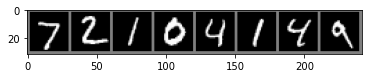

GrondTruth:      7     2     1     0     4     1     4     9


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [11]:
images = images.cuda()
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted(net_plain): ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size))) 


Predicted(net_plain):      7     2     1     0     4     1     4     9


In [12]:
test(net)

Accuracy of the network on the test images: 99 %
Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
